In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)

In [2]:
def plot_training_hist(training_hist):
    '''
    training_hist: Dataframe constructed from hist.hist from training results.
    '''
    f, a = plt.subplots(1)
    a.plot(training_hist['loss'], label='loss')
    a.plot(training_hist['val_loss'], label='validation loss')
    a.set_xlabel('Epoch')
    a.set_ylabel('Error [Sales Price]')
    a.grid(1)
    a.legend()

In [3]:
def calcate_fig_shape(cols):
    total_figs = len(cols)
    vlen = int(total_figs**0.5)
    hlen = int(np.ceil(total_figs / vlen))
    print(f"Shape of fig: {(vlen, hlen)}")
    return vlen, hlen

def plot_scatter_matrix(df, cols):
    vlen, hlen = calcate_fig_shape(cols)
    f, a = plt.subplots(vlen, hlen, figsize = (25,12))
    for ax, col in zip(a.flatten(), cols):
        ax.set_title(col)
        pdf = df[[col, 'SalePrice']].dropna(axis=0)
        ax.scatter(pdf[col], pdf['SalePrice'])
        
    # Remove extra axes.
    extra_plots_last_row =  a.size - len(cols)
    if extra_plots_last_row:
        for extra in a[-1][-extra_plots_last_row:]:
            extra.axis('off')
    plt.tight_layout()

def plot_box_matrix(df, cols):
    vlen, hlen = calcate_fig_shape(cols)
    f, a = plt.subplots(vlen, hlen, figsize = (25,12))
    for ax, col in zip(a.flatten(), cols):
        ax.set_title(col)
        pdf = df[[col, 'SalePrice']].dropna(axis=0)
        all_cats = df[col].unique()
        ax.boxplot([pdf.loc[pdf[col]==c, 'SalePrice'] for c in all_cats], labels=all_cats)
        if len(all_cats) > 5:
            ax.tick_params(axis='x', labelrotation= 45)
        
    # Remove extra axes.
    extra_plots_last_row =  a.size - len(cols)
    if extra_plots_last_row:
        for extra in a[-1][-extra_plots_last_row:]:
            extra.axis('off')
    plt.tight_layout()

def plot_hist_matrix(df, cols):
    vlen, hlen = calcate_fig_shape(cols)
    f, a = plt.subplots(vlen, hlen, figsize = (25,12))
    for ax, col in zip(a.flatten(), cols):
        ax.set_title(col)
        all_cats = df[col].unique()
        counts = df[col].value_counts()
        counts = counts / counts.sum() * 100
        ax.bar(counts.index, counts)
        if len(all_cats) > 5:
            ax.tick_params(axis='x', labelrotation= 45)
        ax.set_ylabel('%')

    # Remove extra axes.
    extra_plots_last_row =  a.size - len(cols)
    if extra_plots_last_row:
        for extra in a[-1][-extra_plots_last_row:]:
            extra.axis('off')
    plt.tight_layout()

In [4]:
def label_columns(df, cols, label):
    for col in cols:
        df[col] = df[col].map(label).fillna(0).astype(int)

## Data Cleaning
1. NaN values
2. Label the categorical values with order -- 주로 qualitative grade.
    - pd.get_dummy 에서 NaN column사용하는 것도 생각해봐.

In [5]:
train_df = pd.read_csv('rsc/train.csv')
test_df = pd.read_csv('rsc/test.csv')

In [7]:
# Merge Train and test data to Fill NaN values
df= pd.concat([train_df, test_df]).reset_index(drop=True)

In [8]:
# Columns with NaN.
nan_count = df.isna().sum() 
nan_count_table = (nan_count[nan_count > 0] / len(df) * 100).round(2).to_frame("NaN Precent [%]")
print("Columns that have NaN values:", )
nan_count_table

Columns that have NaN values:


,NaN Precent [%]
MSZoning,0.14
LotFrontage,16.65
Alley,93.22
Utilities,0.07
Exterior1st,0.03
Exterior2nd,0.03
MasVnrType,0.82
MasVnrArea,0.79
BsmtQual,2.77
BsmtCond,2.81


In [9]:
# Separate the categorical columns and numeric columns.
categorical_cols = df.dtypes[df.dtypes == object].index
numeric_cols = df.dtypes[df.dtypes != object].index

In [10]:
# Columns with NA category
na_cat = ['Alley', 'MasVnrType','GarageType', 'MiscFeature']
for c in na_cat:
    df[c] = df[c].fillna('NA')

# Columns that NaN should be zero -- numeric
zero_cat = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
for c in na_cat:
    df[c] = df[c].fillna(0)

In [11]:
# Categorical cols' NaN get mode
for c in categorical_cols:
    df[c] = df[c].fillna(df[c].mode()[0])
# Numeric cols' NaN get median
for c in numeric_cols:
    df[c] = df[c].fillna(df[c].median())

In [12]:
# Columns with NaN.
tot_nan_count = df.isna().sum().sum()
print('NaN count', tot_nan_count)

NaN count 0


### Label Qualitative Columns

In [13]:
# columns : labels -- int, qualitative
grading_scheme =[
    (['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'], {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2,'Po':1, np.nan:0}),
    (['BsmtExposure'], {'Gd':4, 'Av':3, 'Mn':2,'No':1, np.nan:0}),
    (['BsmtFinType1', 'BsmtFinType2'], {'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3,'LwQ':2,'Unf':1, np.nan:0}),
    (['Functional'], {'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4,'Maj1':3,'Maj2':2, 'Sev':1, 'Sal':0}),
    (['GarageFinish'], {'Fin':3, 'RFn':2,'Unf':1, np.nan:0}),
    (['PavedDrive', 'CentralAir'], {'Y':2,'P':1,'N':0}),
    (['Fence'], {'GdPrv':4, 'MnPrv':3, 'GdWo':2,'MnWw':1, np.nan:0})
]
for cols_to_label, label in grading_scheme:
    label_columns(df, cols_to_label, label)

In [14]:
# Separate the categorical columns and numeric columns.
categorical_cols = df.dtypes[df.dtypes == object].index
numeric_cols = df.dtypes[df.dtypes != object].index

## Feature Selection
### 1. Categorical

First, let's look at the categorical features. I want features that are at least somewhat evenly distributed.\
If a feature is not evenly distributed, it cannot be a good distinguishing factor.\
I don't want any feature that has one category dominating more than 70% of the sample.

In [15]:
train_df = df[:len(train_df)]
test_df = df[len(train_df):].drop(columns=['SalePrice'])

In [16]:
def find_unevenly_dist_cols(df, cols):
    '''
    Use this for categorical columns
    '''
    uneven_cat_cols = []
    for c in cols:
        counts = df[c].value_counts()
        counts /= counts.sum()
        if (counts > 0.7).any():
            uneven_cat_cols.append(c)
    return uneven_cat_cols

In [17]:
uneven_cat_cols = find_unevenly_dist_cols(df, categorical_cols)
even_cat_cols = set(categorical_cols) - set(uneven_cat_cols)

Shape of fig: (2, 4)


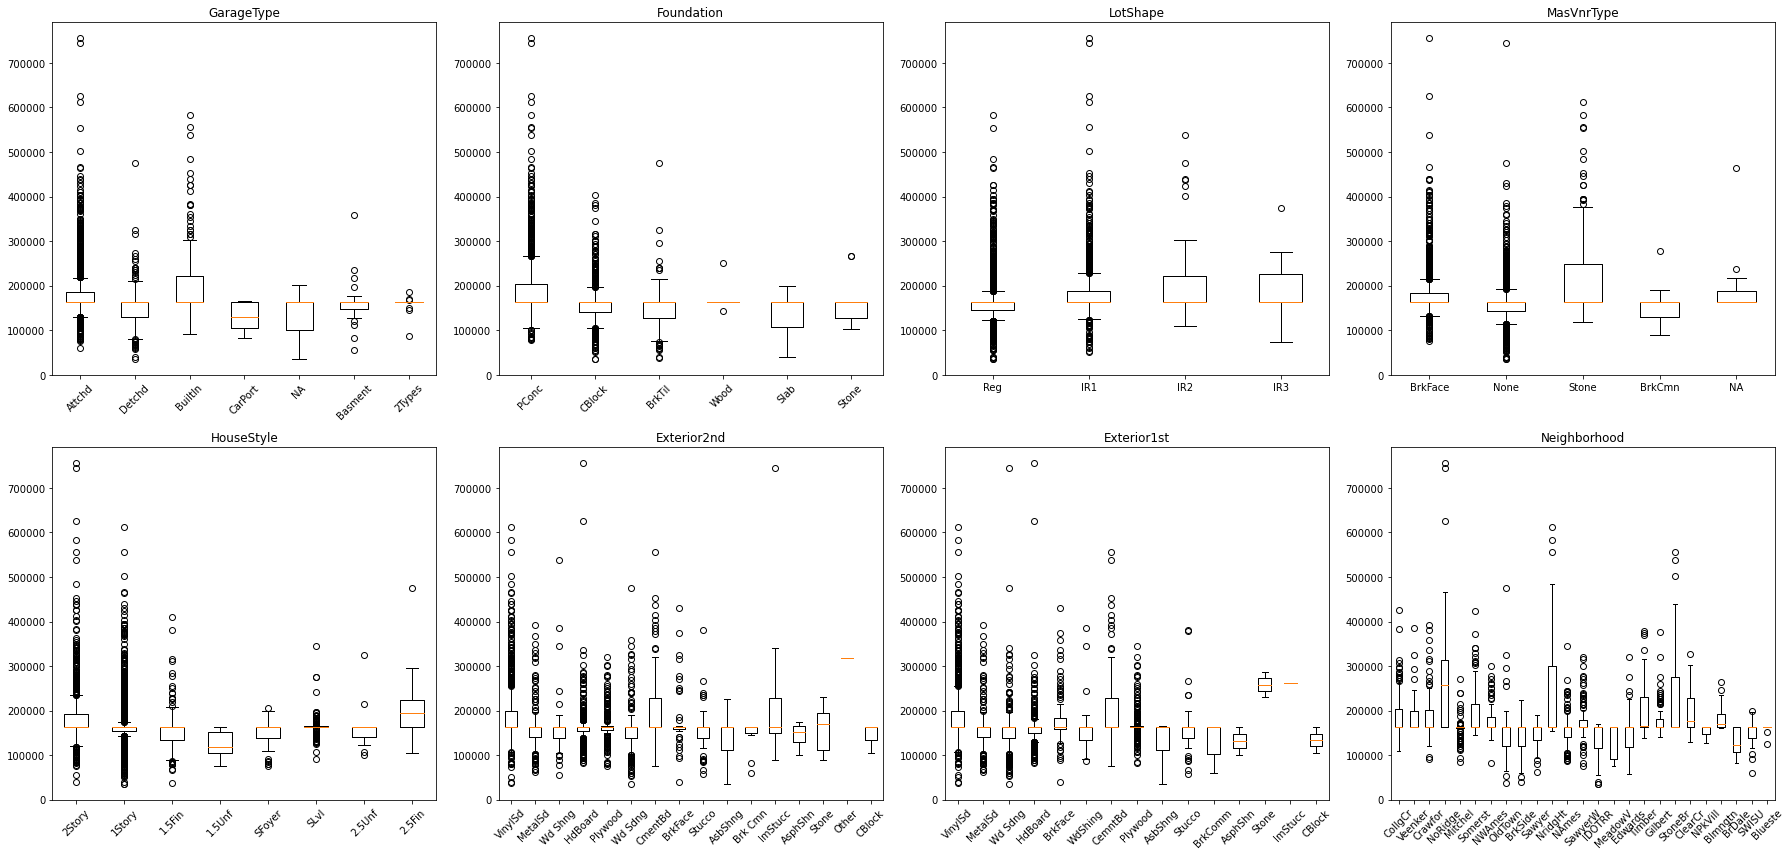

In [18]:
plot_box_matrix(df, even_cat_cols)

Most of the features' categories are distinguishing.\
but Exterior features for example, may not be too effective as there are many different categories without significant difference in median.

### 2. Numerical
This set includes qualitative features that were converted to integer values.\
Same procedure goes here. Start with the distribution.

Shape of fig: (7, 8)


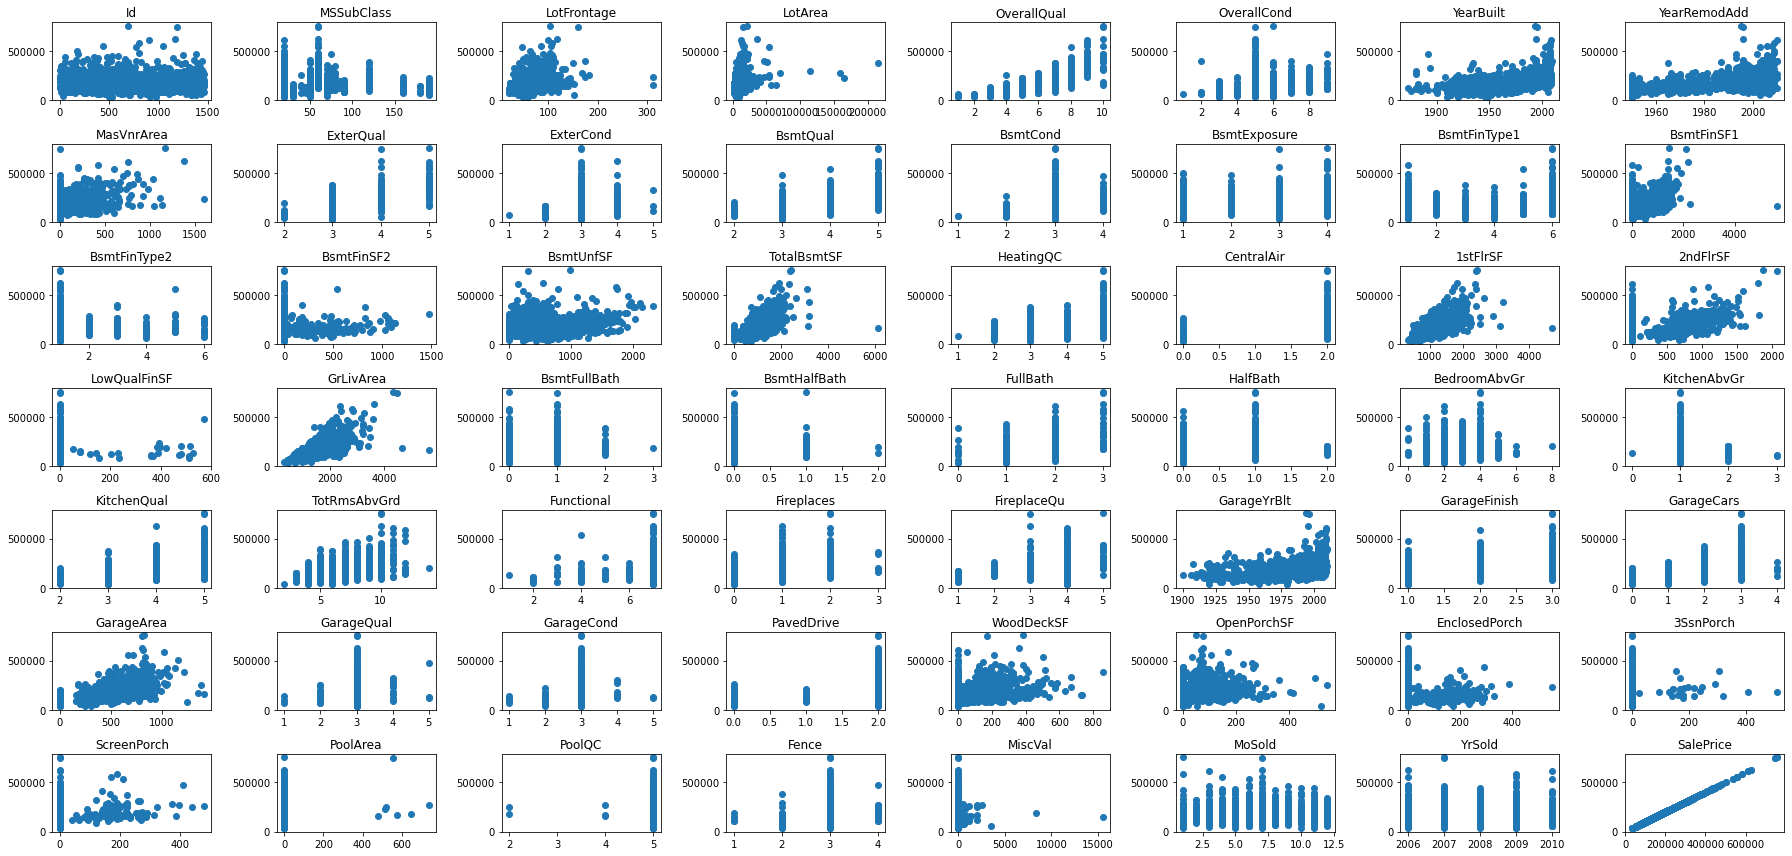

In [19]:
#여기는 train only. SalePrice가 필요하니깐
plot_scatter_matrix(train_df, numeric_cols)

It's easy to spot features that have correlations from the graph.\
But let's calculate the correlation coefficient to quantify the relationships.\
I'll be starting with features with correlation coeff higher than 0.5. -- start with the obivous ones.

In [20]:
#여기는 train only. SalePrice가 필요하니깐
corr = train_df[numeric_cols].corr()
strong_numeric_features = corr['SalePrice'][corr['SalePrice'].abs() > 0.5].index
print("strong numeric features", len(strong_numeric_features))
print(strong_numeric_features.tolist())

strong numeric features 15
['OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'BsmtQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual', 'TotRmsAbvGrd', 'GarageFinish', 'GarageCars', 'GarageArea', 'SalePrice']


In [21]:
def plot_correlation_heatmap(df, cols):
    fig, ax = plt.subplots(figsize=(20,20))
    im = ax.imshow(df[cols].corr())
    ax.set_xticks(np.arange(len(cols)))
    ax.set_yticks(np.arange(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_yticklabels(cols)
    ax.set_title('Correlation plot')
    _ = plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    _ = cbar.ax.set_ylabel("Pearson score", rotation=-90, va="bottom")

Now, I need to check for colinearity between the strong features.

There seems to be some correlation between the strong features. I need to avoid this. \
Let's quantify this.

In [22]:
# selected_numeric = handle_collinearity(high_corr_df)
selected_numeric = strong_numeric_features  # 안하는 게 더 낫다.

In [23]:
print("Categoricals, :", even_cat_cols)
print("Numercals, :", set(selected_numeric))

Categoricals, : {'GarageType', 'Foundation', 'LotShape', 'MasVnrType', 'HouseStyle', 'Exterior2nd', 'Exterior1st', 'Neighborhood'}
Numercals, : {'1stFlrSF', 'GarageFinish', 'KitchenQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'OverallQual', 'ExterQual', 'GarageCars', 'TotRmsAbvGrd', 'SalePrice', 'YearRemodAdd', 'GarageArea', 'FullBath', 'BsmtQual'}


In [24]:
# 여기서 IQR을 사용해서 outlier들 floor ceiling하자.
def cap_outliers(df, cols):
    ''' 간단히 말해서 IQR 로 ceiling, floor하는 작업임... 미쳤나?'''
    
    q1 = df[cols].quantile(0.25)
    q3 = df[cols].quantile(0.75)

    iqr = q3 - q1

    lower = q1 -(1.5 * iqr) 
    upper = q3 +(1.5 * iqr)
    
    for c in cols:
        df.loc[df[c]<lower[c], c] = lower[c]
        df.loc[df[c]>upper[c], c] = upper[c]

cap_outliers(df, selected_numeric)

In [25]:
df_onehot = pd.get_dummies(df, columns=even_cat_cols, drop_first=True)
total_dataset = df_onehot
train_dataset = df_onehot[:len(train_df)]
test_dataset = df_onehot[len(train_df):]
target = df[:len(train_df)]['SalePrice']

In [26]:
# Trial & Error
final_features = ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual','TotalBsmtSF','GrLivArea', 'GarageCars',
                           # *train_dataset.columns[train_dataset.columns.map(lambda x: x.startswith('LotShape'))],
                            *train_dataset.columns[train_dataset.columns.map(lambda x: x.startswith('Neighborhood'))],
#                             'KitchenQual', 
                  #'GarageArea',#, 'BsmtQual'
                     
                 ]
total_input = total_dataset[final_features]
train_input= train_dataset[final_features]
test_input= test_dataset[final_features]

# 역효과: 'FullBath', 'FireplaceQu','GarageFinish', 'Foundation', 'Exterior1st', 'GarageType', 'MasVnrType', 'Exterior2nd', 'HouseStyle'

# Regression Part

In [27]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
physical_devices = tf.config.list_physical_devices('GPU')
print(f'Tensorflow found {len(physical_devices)} GPU.')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Tensorflow found 1 GPU.


### Multi variate regression


In [28]:
dnn_norm = Normalization(input_shape=(total_input.shape[1],))
dnn_norm.adapt(total_input.to_numpy())

In [29]:
dnn_model = tf.keras.models.Sequential([
    dnn_norm,
    Dense(128, activation='relu', kernel_initializer='normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_initializer='normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_initializer='normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1)
])
dnn_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='MAE')

In [30]:
checkpoint_filepath = 'models/cp'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [31]:
history = dnn_model.fit(train_input, target,
             validation_split=0.2,
             epochs=200,
            batch_size=64,
            verbose=False, callbacks=[model_checkpoint_callback])
dnn_model.load_weights(checkpoint_filepath)

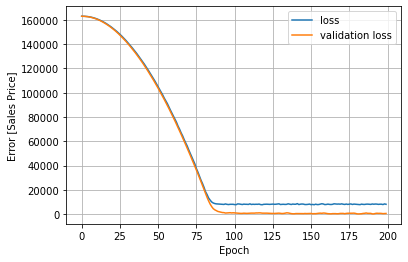

In [32]:
training_hist = pd.DataFrame.from_dict(history.history, orient='columns')
training_hist.index.name = 'epoch'
plot_training_hist(training_hist)

In [33]:
training_hist.min()

loss        7749.383789
val_loss     186.854080
dtype: float64

In [34]:
training_hist.tail()

,loss,val_loss
epoch,,
195,8183.463867,669.227112
196,8193.765625,586.869629
197,7907.129395,410.055695
198,8420.483398,482.226288
199,8128.005371,565.146606


In [35]:
test_dataset

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,...,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
1460,1461,20,RH,80.0,11622,Pave,NA,Lvl,AllPub,Inside,Gtl,Feedr,Norm,1Fam,5.0,6,1961.0,1961.0,Gable,CompShg,0.0,3.0,3,3.0,3,1,3,468.0,2,144.0,270.0,882.0,GasA,3,2,SBrkr,896.0,0,0,896.0,0.0,0.0,1.0,0,2,1,3.0,5.0,7,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1461,1462,20,RL,81.0,14267,Pave,NA,Lvl,AllPub,Corner,Gtl,Norm,Norm,1Fam,6.0,6,1958.0,1958.0,Hip,CompShg,108.0,3.0,3,3.0,3,1,5,923.0,1,0.0,406.0,1329.0,GasA,3,2,SBrkr,1329.0,0,0,1329.0,0.0,0.0,1.0,1,3,1,4.0,6.0,7,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1462,1463,60,RL,74.0,13830,Pave,NA,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,5.0,5,1997.0,1998.0,Gable,CompShg,0.0,3.0,3,4.0,3,1,6,791.0,1,0.0,137.0,928.0,GasA,4,2,SBrkr,928.0,701,0,1629.0,0.0,0.0,2.0,1,3,1,3.0,6.0,7,1,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1463,1464,60,RL,78.0,9978,Pave,NA,Lvl,AllPub,Inside,Gtl,Norm,Norm,1Fam,6.0,6,1998.0,1998.0,Gable,CompShg,20.0,3.0,3,3.0,3,1,6,602.0,1,0.0,324.0,926.0,GasA,5,2,SBrkr,926.0,678,0,1604.0,0.0,0.0,2.0,1,3,1,4.0,7.0,7,1,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1464,1465,120,RL,43.0,5005,Pave,NA,HLS,AllPub,Inside,Gtl,Norm,Norm,TwnhsE,8.0,5,1992.0,1992.0,Gable,CompShg,0.0,4.0,3,4.0,3,1,5,263.0,1,0.0,1017.0,1280.0,GasA,5,2,SBrkr,1280.0,0,0,1280.0,0.0,0.0,2.0,0,2,1,4.0,5.0,7,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NA,Lvl,AllPub,Inside,Gtl,Norm,Norm,Twnhs,4.0,7,1970.0,1970.0,Gable,CompShg,0.0,3.0,3,3.0,3,1,1,0.0,1,0.0,546.0,546.0,GasA,4,2,SBrkr,546.0,546,0,1092.0,0.0,0.0,1.0,1,3,1,3.0,5.0,7,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2915,2916,160,RM,21.0,1894,Pave,NA,Lvl,AllPub,Inside,Gtl,Norm,Norm,TwnhsE,4.0,5,1970.0,1970.0,Gable,CompShg,0.0,3.0,3,3.0,3,1,3,252.0,1,0.0,294.0,5

In [39]:
test_predictions = dnn_model.predict(test_dataset[final_features]).flatten().round(0)
submission = pd.DataFrame(test_predictions, index=test_dataset['Id'], columns=['SalePrice'])
submission.index.name = 'Id'
submission.head()

,SalePrice
Id,
1461,162964.0
1462,163022.0
1463,162816.0
1464,162772.0
1465,162572.0


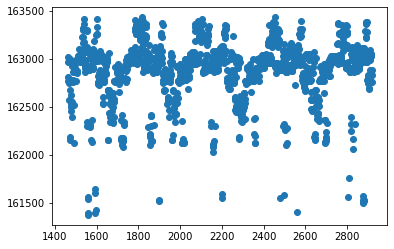

In [41]:
f,a = plt.subplots(1)
a.scatter(submission.index, submission['SalePrice'])

In [43]:
submission.to_csv('results/IQR to cap outlier.csv')